## Environment Setting

Google drive mount (for Colab users) and package importing.
You can optionally work on a transformer part.


In [ ]:
# For Colab users
from google.colab import drive

drive.mount("/content/drive", force_remount=True)

import sys

sys.path.insert(0, "/content/drive/{path to project directory}")

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
import json

from data_utils import MLDataset, collate_fn
# from modeling_challenge import Seq2SeqTransformerModel
from modeling_1 import Seq2SeqTransformerModel

## (Optional) Sample Visualization

You can see actual sample images and correct answers. Additional matplotlib package is needed.


In [2]:
# Just for reference: see actual samples
import matplotlib.pyplot as plt

id_to_char = {}
alphabets = "abcdefghijklmnopqrstuvwxyz"
for i, c in enumerate(alphabets):
    id_to_char[i + 1] = c

Answer: hear ([8, 5, 1, 18])
Input image sequence:


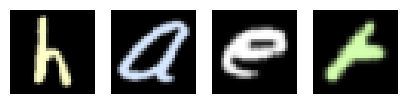

In [3]:
# Just for reference: see actual samples
idx = 1234
sample = np.load(f"./data_final/imgs/train/{idx}.npy")
with open("./data_final/labels/train.json", "r") as f:
    sample_target = json.load(f)[str(idx)]

tgt_char = ""
for i in sample_target:
    tgt_char += id_to_char[i]


print(f"Answer: {tgt_char} ({sample_target})")
print("Input image sequence:")

plt.figure(figsize=(5, len(sample)))
for i, img in enumerate(sample):
    plt.subplot(1, len(sample), i + 1)
    plt.axis("off")
    plt.imshow(img)

## Device and seed setting


In [4]:
assert torch.cuda.is_available()

# Use 0th GPU for training
torch.cuda.set_device(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# fix random seed to increase reproducibility
# NOTE: Do not modify here!
NUM_CLASSES = 26 + 2  # 26 alphabets + 1 padding index + 1 <s> token (start token)

random_seed = 7
torch.manual_seed(random_seed)
os.environ["PYTHONHASHSEED"] = str(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.cuda.manual_seed(random_seed)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# %env CUBLAS_WORKSPACE_CONFIG=:16:8


def seed_worker(worker_seed):
    np.random.seed(worker_seed)
    random.seed(worker_seed)


num_workers = 8

## Model loading and training


In [5]:
# NOTE: modify path and batch size for your setting
# NOTE: you can apply custom preprocessing to the training data

BATCH_SIZE = 128

train_ds = MLDataset("data_final/imgs/train", "data_final/labels/train.json")
valid_ds = MLDataset(
    "data_final/imgs/valid_normal", "data_final/labels/valid_normal.json"
)
challenge_ds = MLDataset(
    "data_final/imgs/valid_challenge", "data_final/labels/valid_challenge.json"
)

train_dl = DataLoader(
    train_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True
)
valid_dl = DataLoader(
    valid_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False
)
challenge_dl = DataLoader(
    challenge_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False
)

In [6]:
# You can add or modify your Seq2SeqModel's hyperparameter (keys and values)
kwargs = {
    'hidden_dim': 128,   # Hidden dimension size for Transformer
    'num_layers': 3,  # Number of layers in the Transformer
    'nhead': 8,  # Number of heads in the multi-head attention
    'decoder_dropout': 0.6,  # Dropout rate for the decoder
    'cnn_settings': {   # Settings for the CustomCNN
        'block1_dim': 32,
        'block2_dim': 64,
        'block3_dim': 128,
        'fc_dim': 128,
        'model_type': 'VGG'  # Type of CNN ('VGG' or 'ResNet')
    },
}

In [7]:
# model = Seq2SeqTransformerModel(num_classes=NUM_CLASSES, **kwargs).to(device)
model = Seq2SeqTransformerModel(num_classes=NUM_CLASSES, **kwargs).to(device)
print(model)
##############################################################################
#                          IMPLEMENT YOUR CODE                               #
##############################################################################
model_optim = model_optim = torch.optim.AdamW(model.parameters(), lr=0.0005)
loss_fn = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(model_optim, step_size=10, gamma=0.5)
# NOTE: you can define additional components like lr_scheduler, ...
##############################################################################
#                          END OF YOUR CODE                                  #
##############################################################################

Seq2SeqTransformerModel(
  (encoder): TransformerEncoder(
    (cnn): CustomCNN(
      (block1): VGGBlock(
        (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (block2): VGGBlock(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (block3): VGGBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (fc): Linear(in_features=1152, out_feat

In [8]:
# NOTE: you can freely modify or add training hyperparameters
print_interval = 1000
max_epoch = 30
patience = 2
vis = True

In [11]:
def train(
    model,
    model_optim,
    loss_fn,
    max_epoch,
    train_dl,
    valid_dl,
    scheduler,
    load_path=None,
    save_path="./model.pt",
    patience=5
):
    # Load states if a path is provided
    loaded_epoch = 0
    loaded_best_valid_loss = -1
    if load_path is not None:
        state = torch.load(load_path)
        model.load_state_dict(state["model"])
        model_optim.load_state_dict(state["optimizer"])
        loaded_epoch = state["epoch"]
        loaded_best_valid_loss = state["best_valid_loss"]

    best_valid_loss = float('inf') if loaded_best_valid_loss == -1 else loaded_best_valid_loss

    # Early stopping criteria
    no_improvement_epochs = 0

    # Initialize lists to store loss values
    train_losses = []
    valid_losses = []
    accuracies = []

    for epoch in range(max_epoch):
        step = 0
        train_loss = 0
        model.train()

        for batch_idx, (data, target, lengths) in enumerate(tqdm(train_dl)):
            data, target = data.to(device), target.to(device)

            # Prepare the start tokens for the decoder input
            start_tokens = (torch.ones([target.size(0), 1]) * 27).to(torch.long).to(device)
            decoder_input = torch.cat([start_tokens, target[:, :-1]], dim=1)

            model_optim.zero_grad()

            # Forward pass
            logits = model(data, lengths, decoder_input)

            # Reshape logits and target for CrossEntropyLoss
            logits = logits.view(-1, logits.size(-1))
            target = target.view(-1)

            # Calculate loss
            loss = loss_fn(logits, target)

            # Backward propagation
            loss.backward()

            # Gradient clipping
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Update model parameters
            model_optim.step()

            train_loss += loss.detach().cpu().item()

        train_loss_avg = train_loss / (batch_idx + 1)
        train_losses.append(train_loss_avg)
        print(f"epoch {epoch + 1}, train loss: {train_loss_avg}")

        # Step the scheduler
        scheduler.step()

        valid_loss = 0
        correct_sequences = 0
        total_sequences = 0

        model.eval()

        for batch_idx, (data, target, lengths) in enumerate(tqdm(valid_dl)):
            with torch.no_grad():
                data, target = data.to(device), target.to(device)

                # Prepare the start tokens for the decoder input
                start_tokens = (torch.ones([target.size(0), 1]) * 27).to(torch.long).to(device)
                decoder_input = torch.cat([start_tokens, target[:, :-1]], dim=1)

                # Forward pass for validation
                logits = model(data, lengths, decoder_input)

                # Reshape logits and target for CrossEntropyLoss
                logits = logits.view(-1, logits.size(-1))
                target = target.view(-1)
                loss = loss_fn(logits, target)

                # Calculate sequence-level accuracy
                logits = logits.view(data.size(0), -1, logits.size(-1))
                predicted_sequences = torch.argmax(logits, dim=-1)
                for i in range(data.size(0)):
                    pred_seq = predicted_sequences[i][: int(lengths[i])]
                    target_seq = target.view(data.size(0), -1)[i][: int(lengths[i])]
                    if torch.equal(pred_seq, target_seq):
                        correct_sequences += 1
                    total_sequences += 1

                valid_loss += loss.cpu().item()

        valid_loss /= (batch_idx + 1)
        accuracy = correct_sequences / total_sequences
        accuracies.append(accuracy)
        valid_losses.append(valid_loss)

        print(f"valid epoch: {epoch + 1}, valid loss: {valid_loss:.4f}, accuracy: {accuracy:.4f}")

        if valid_loss < best_valid_loss:
            print("New best valid loss, saving model")
            state = {
                "model": model.state_dict(),
                "optimizer": model_optim.state_dict(),
                "epoch": epoch + 1,
                "best_valid_loss": best_valid_loss,
            }
            torch.save(state, save_path)
            best_valid_loss = valid_loss
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1

        if no_improvement_epochs >= patience:
            print(f"No improvement in validation loss for {patience} epochs. Stopping training.")
            break

    return train_losses, valid_losses, accuracies

In [12]:
load_path = None
train_losses, valid_losses, accuracies = train(
    model,
    model_optim,
    loss_fn,
    max_epoch,
    train_dl,
    valid_dl,
    scheduler,
    load_path=load_path,
    save_path="./model.pt",
)

  6%|▌         | 30/531 [00:04<01:06,  7.48it/s]

In [ ]:
# Plot the training and validation losses over epochs
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="train loss")
plt.plot(valid_losses, label="valid loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Plot the validation accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(accuracies, label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Model evaluation


In [ ]:
kwargs_generate = {
    "max_length": 10,
}

In [ ]:
# Do not modify this cell!


def eval(dataloader, model_path):
    state = torch.load(model_path)
    model.load_state_dict(state["model"])
    model.eval()

    id_to_char = {}
    id_to_char[0] = "<pad>"
    id_to_char[27] = "<s>"
    alphabets = "abcdefghijklmnopqrstuvwxyz"
    for i, c in enumerate(alphabets):
        id_to_char[i + 1] = c

    results = []
    labels = []
    for batch_idx, (data, target, lengths) in enumerate(tqdm(dataloader)):
        data = data.to(device)  # (B, T, H, W, C)
        target = target.to(device)  # (B, T)

        # start tokens should be located at the first position of the decoder input
        start_tokens = (torch.ones([target.size(0), 1]) * 27).to(torch.long).to(device)
        with torch.no_grad():
            generated_tok = model.generate(
                data, lengths, start_tokens, **kwargs_generate
            )  # (B, T)

        for i in range(generated_tok.size(0)):
            decoded = ""
            for j in generated_tok[i][: lengths[i].int()].tolist():
                decoded += id_to_char[j]
            results.append(decoded)

            decoded = ""
            for j in target[i][: lengths[i].int()].tolist():
                decoded += id_to_char[j]
            labels.append(decoded)

    corrects = []
    for i in range(len(results)):
        if results[i] == labels[i]:
            corrects.append(1)
        else:
            corrects.append(0)
    print("Accuracy: %.5f" % (sum(corrects) / len(corrects)))

    return results, labels

In [ ]:
# load and evaluate your model
load_path = "./model.pt"
print("Evaluation with validation set")
results, labels = eval(valid_dl, load_path)

print("Evaluation with challenge set")
results, labels = eval(challenge_dl, load_path)